# Homework 8: Problems
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem 1: Principal Component Analysis

PCA applied to 4-D data for variable stars from the SDSS and LINEAR surveys:

-- SDSS u-g and g-i colors, 

-- LINEAR variability period (logP) and variability amplitude (A).

For more details, see Homework 1 - this is the same data sample.  

Read the data, run PCA (with four components), and then

a) plot P2 vs. P1 diagram, color-coded using P3 and P4 as in Homework 1. 
From Homework 1, retain the g-i vs. u-g and amplitude vs. logP diagrams, 
color-coded by the u-g and g-i colors, for visual comparison. Comment
what insights, if any, did PCA analysis bring. 

b) plot the g-i vs. u-g, amplitude vs. logP, P2 vs. P1 and P4 vs. P3 diagrams, 
color-coded using P1 and P2. Comment what insights, if any, did PCA analysis bring. 


## Problem 2: Regression and age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper "An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf

Given these y(x) data (see below), with errors in both x and y, 
adapt the code introduced in 
[the last lecture](https://github.com/uw-astr-324-s17/astr-324-s17/blob/master/notebooks/Week-8-Thu.ipynb) 
by modifying the parabola (y(x) = a + b*x + c*x^2) fitter to fit instead
the following function

$$ y(x) = a + b*\left[1-exp\left(-(x/c)^d\right)\right].  $$

Important: here x is time, not log(time)! But when you plot, use log(time)
for x axis (see data below).

a) What are the the best-fit values and standard errors for 
parameters a, b, c and d? 

b) Show the marginal distributions of fitted parameters (hint: use plot_mcmc)

c) compare your best fit to the best fit from Jedicke et al. and comment

d) set all age errors to 1000 years (i.e. to 0.001 in Myr): 
do you get a different best fit? 

<br>
# Homework 1: Solutions

### Some useful definitions and functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pymc as pymc
#import seaborn as sns
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_LINEAR_geneva
from astroML.plotting import setup_text_plots
from scipy import optimize
np.random.seed(42)
setup_text_plots(fontsize=8, usetex=True)
%matplotlib inline

Let's define a few more useful functions:

In [2]:
def black_bg_subplot(*args, **kwargs):
# copied from http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """Create a subplot with black background"""
    kwargs['axisbg'] = 'k'
    ax = plt.subplot(*args, **kwargs)

    # set ticks and labels to white
    for spine in ax.spines.values():
        spine.set_color('w')

    for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        for child in tick.get_children():
            child.set_color('w')

    return ax

In [3]:
def compute_color2(vec1, vec2, kG=5.0, aG=0.8, kB=2.0, aB=1.2):
# adopted from http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """
    Compute the scatter-plot color using code adapted from astroML
    http://www.astroml.org/book_figures/chapter1/fig_moving_objects_multicolor.html
    """
    # define the base color scalings
    # fudge factors aG and aB control the "redness" and "greenness"
    # fudge factors kG and kB control dynamic range of color coding
    # both a and k factors need some experimenting for the best results
    R = np.ones_like(vec1)
    G = aG * 10**(kG*vec1) 
    B = aB * 10**(kB*vec2) 

    # normalize color of each point to its maximum component
    RGB = np.vstack([R, G, B])
    RGB /= RGB.max(0)

    # return an array of RGB colors, which is shape (n_points, 3)
    return RGB.T

## Problem 1

First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [4]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
ug = data['ug']
gi = data['gi']
logP = data['logP']
A = data['amp']
print data.dtype.names

('RA', 'Dec', 'ug', 'gi', 'iK', 'JK', 'logP', 'amp', 'skew', 'kurt', 'magMed', 'nObs', 'LCtype', 'LINEARobjectID')


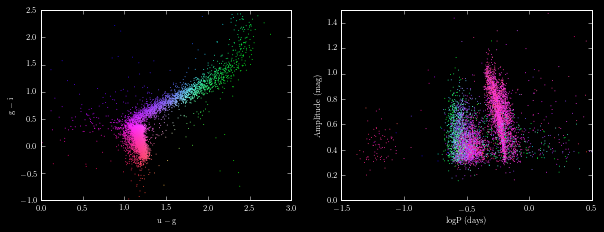

In [5]:
# first plot diagrams as in HW #1
ugNorm = (ug-1.5)/(3.0-0.0)
giNorm = (gi-0.5)/(2.5+1.0)
color = compute_color2(ugNorm, giNorm, 5.0, 0.8, 2.0, 1.2)

# set up the plot
fig = plt.figure(figsize=(9, 7), facecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2,
                    bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = black_bg_subplot(221)
ax1.scatter(ug, gi, c=color, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='w')
ax1.set_ylabel(r'${\rm g-i}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(222)
ax2.scatter(logP, A, c=color, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='w')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='w')

And then do the PCA analysis...

In [6]:
from sklearn.decomposition import PCA
X = np.column_stack((ug, gi, logP, A))
pca = PCA(n_components=4, whiten=False)  
pca.fit(X) # call the work horse 
## now figure out how to get PC1-PC4...

comp = pca.transform(X)
P1 = comp[:,0]
P2 = comp[:,1]
P3 = comp[:,2]
P4 = comp[:,3]

In [7]:
mean = pca.mean_
components = pca.components_
var = pca.explained_variance_

In [8]:
P1Norm = (P1 + 0.2)/(1.3)
P2Norm = (P2 - 0.7)/(3.5)
P3Norm = (P3 - 0.0)/(2.0)
P4Norm = (P4 - 0.1)/(1.2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in power
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


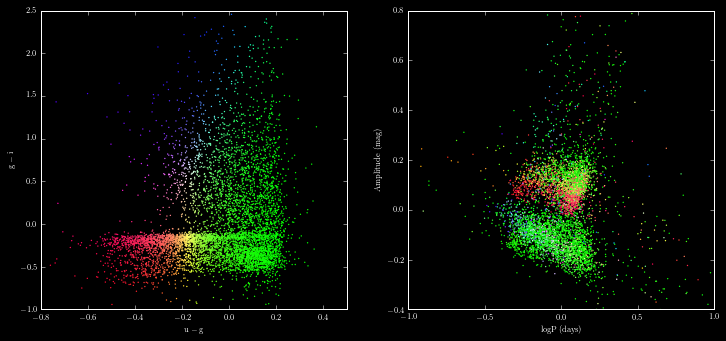

In [9]:
# first plot diagrams as in HW #1
color = compute_color2(P1Norm, P2Norm)

# set up the plot
fig = plt.figure(figsize=(11, 11), facecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2,
                    bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = black_bg_subplot(221)
ax1.scatter(P1, P2, c=color, s=1.9, lw=0)
ax1.set_xlim(-0.8, 0.5)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='w')
ax1.set_ylabel(r'${\rm g-i}$', color='w')

# plot the A vs. logP plot
ax2 = black_bg_subplot(222)
ax2.scatter(P3, P4, c=color, s=1.9, lw=0)
ax2.set_xlim(-1.0, 1.0)
ax2.set_ylim(-0.4, 0.8)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='w')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='w')


Now compute RGB color based on P3 and P4, etc...

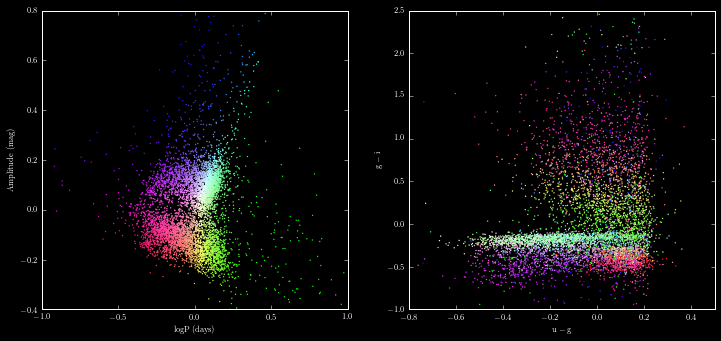

In [10]:
# first plot diagrams as in HW #1
color1 = compute_color2(P3Norm, P4Norm)

# set up the plot
fig = plt.figure(figsize=(11, 11), facecolor='k')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2,
                    bottom=0.1, top=0.93)

# plot the A vs. logP plot
ax3 = black_bg_subplot(223)
ax3.scatter(P3, P4, c=color1, s=1.9, lw=0)
ax3.set_xlim(-1.0, 1.0)
ax3.set_ylim(-0.4, 0.8)
ax3.set_xlabel(r'${\rm logP \, (days)}$', color='w')
ax3.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='w')

# plot the color-color plot
ax4 = black_bg_subplot(224)
ax4.scatter(P1, P2, c=color1, s=1.9, lw=0)
ax4.set_xlim(-0.8, 0.5)
ax4.set_ylim(-1.0, 2.5)
ax4.set_xlabel(r'${\rm u-g}$', color='w')
ax4.set_ylabel(r'${\rm g-i}$', color='w')

## Problem 2

These age and color data for asteroid families are taken
from the paper Jedicke et al. (2004, Nature 429, 275), see fig. 1 in http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf



In [11]:
# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)
# set ageErr to 1000 years for all data points
# ageErr = 0.001 + 0*ageErr

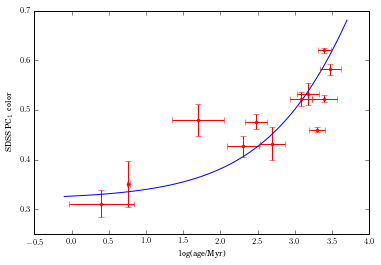

In [12]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure().add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show()

In [13]:
### now let's redo doMCMCparabola from the lecture to be able to fit instead
### y = a + b*[1-exp(-(x/c)^d)]  
import pymc as pymc
from astroML.plotting.mcmc import plot_mcmc

In [41]:
def doMCMCparabola(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        a = pymc.Uniform('a', -1000, 1000, value= 1.0)
        b = pymc.Uniform('b', -1000, 1000, value= 0.0)
        c = pymc.Uniform('c', -1000, 1000, value= 1000)
        d = pymc.Uniform('d', -1000, 1000, value= 1.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def parabola(x=xLatent, a=a, b=b, c=c, d=d):
            return (a + b*(1.0 - np.exp(-(x/c)**d)))
    
        y = pymc.Normal('y', mu=parabola, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['a', 'b', 'c', 'd']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.a.value, M.b.value, M.c.value, M.d.value)
    return traces, fit_vals

def doMCMCparabola(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        a = pymc.Uniform('a', -1000, 1000, value= 1.0)
        b = pymc.Uniform('b', -1000, 1000, value= 1.0)
        c = pymc.Uniform('c', -1000, 1000, value= 1.0)
        d = pymc.Uniform('d', -1000, 1000, value= 1.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def parabola(x=xLatent, a=a, b=b, c=c, d=d):
            return a + b * (1 - np.exp(-(x/c)**d))
    
        y = pymc.Normal('y', mu=parabola, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['a', 'b', 'c', 'd']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.a.value, M.b.value, M.c.value, M.d.value)
    return traces, fit_vals

In [45]:
np.seterr(divide='ignore', invalid='ignore')
traces, fit_vals = doMCMCparabola(age, PC1, ageErr, PC1err, True, 100000, 10000)

 [-----------------100%-----------------] 100000 of 100000 complete in 32.0 sec

In [46]:
print "a:", fit_vals[0]
print "b:", fit_vals[1]
print "c:", fit_vals[2]
print "d:", fit_vals[3]

a: 0.323459944578
b: 0.346801300971
c: 999.971493914
d: 0.605697999776


<function matplotlib.pyplot.show>

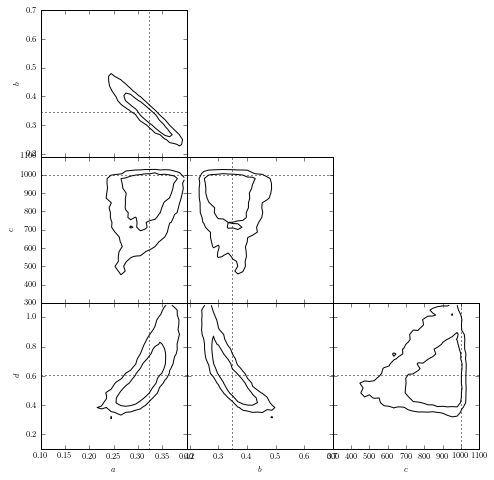

In [47]:
labels = ['$a$','$b$','$c$','$d$']
limits = [(0.10,0.40),(0.19,0.70),(300,1100),(0.1,1.1)]
TLS = [fit_vals[0],fit_vals[1],fit_vals[2],fit_vals[3]]

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

plot_mcmc(traces, labels=labels, limits=limits, true_values=TLS,
         fig=fig, bins=30, colors='k')

plt.show

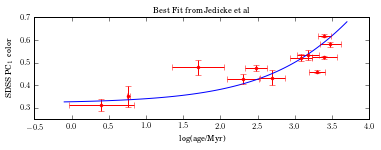

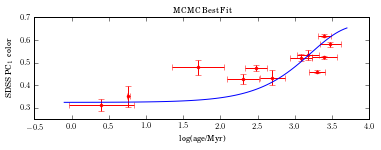

In [48]:
### y = a + b*[1-exp(-(x/c)^d)]  
yfitParabola = fit_vals[0] + fit_vals[1] * (1 - np.exp(-(time / fit_vals[2])) ** fit_vals[3])

fig = plt.figure(figsize=(15, 15), facecolor='k')

ax1 = plt.figure().add_subplot(211)
ax1.set_xlabel("log(age/Myr)")
ax1.set_ylabel("SDSS PC$_1$ color")
ax1.set_title("Best Fit from Jedicke et al")
ax1.plot(logT,color, c='blue')
ax1.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')

ax2 = plt.figure().add_subplot(212)
ax2.set_xlabel("log(age/Myr)")
ax2.set_ylabel("SDSS PC$_1$ color")
ax2.set_title("MCMC Best Fit")
ax2.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
ax2.plot(logT,yfitParabola,'-', c='blue', label='parabola')
plt.show()

With the new best fit curve, we can see that the color increases more rapidly than the Jedicke, starting at about 0.25 Myr, and more interestingly levels off starting at about 0.32 Myr.

In [69]:
new_logAgeErr = np.empty(12)
new_logAgeErr.fill(0.001)
new_ageErr = np.empty(12)
new_ageErr.fill(1000)
np.random.seed(42)

np.seterr(divide='ignore', invalid='ignore')
traces1, fit_vals1 = doMCMCparabola(age, PC1, new_ageErr, PC1err, True, 100000, 10000)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


 [-----------------100%-----------------] 100000 of 100000 complete in 30.3 sec

In [70]:
print "New a:", fit_vals1[0]
print "New b:", fit_vals1[1]
print "New c:", fit_vals1[2]
print "New d:", fit_vals1[3]
a1 = fit_vals1[0]
b1 = fit_vals1[1]
c1 = fit_vals1[2]
d1 = fit_vals1[3]

New a: 0.340211065303
New b: -0.0392279908055
New c: -951.020779601
New d: 1.0


<function matplotlib.pyplot.show>

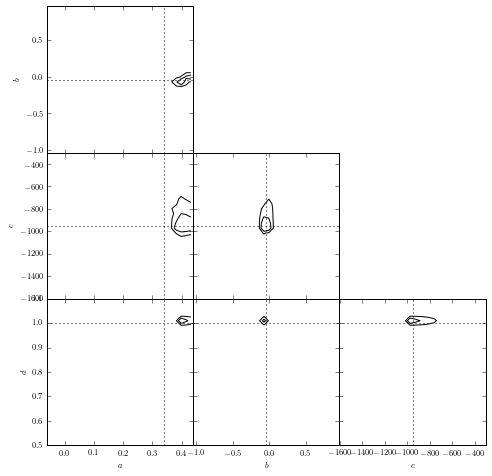

In [71]:
labels = ['$a$','$b$','$c$','$d$']
limits = [(a1-0.4,a1+0.1),(b1-1,b1+1),(c1-650,c1+650),(d1-0.5,d1+0.1)]
TLS1 = [fit_vals1[0],fit_vals1[1],fit_vals1[2],fit_vals1[3]]

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

plot_mcmc(traces1, labels=labels, limits=limits, true_values=TLS1,
         fig=fig, bins=30, colors='k')

plt.show

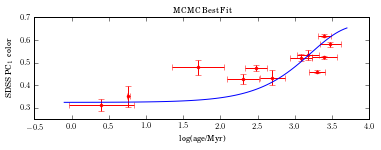

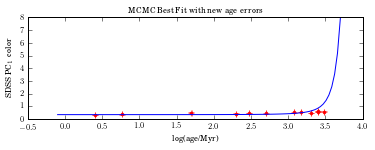

In [72]:
### y = a + b*[1-exp(-(x/c)^d)]  
yfitParabola1 = fit_vals1[0] + fit_vals1[1] * (1 - np.exp(-(time / fit_vals1[2])) ** fit_vals1[3])

fig = plt.figure(figsize=(15, 15), facecolor='k')

ax2 = plt.figure().add_subplot(211)
ax2.set_xlabel("log(age/Myr)")
ax2.set_ylabel("SDSS PC$_1$ color")
ax2.set_title("MCMC Best Fit")
ax2.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
ax2.plot(logT,yfitParabola,'-', c='blue', label='parabola')

ax3 = plt.figure().add_subplot(212)
ax3.set_xlabel("log(age/Myr)")
ax3.set_ylabel("SDSS PC$_1$ color")
ax3.set_title("MCMC Best Fit with new age errors")
ax3.errorbar(logAge,PC1,xerr=new_logAgeErr, yerr=PC1err, color='r', 
              marker='.', ls='None', label='Observed')
ax3.plot(logT,yfitParabola1,'-', c='blue', label='parabola')

plt.show()

When the errors are changed to 1000 years for each observations, the new fit curve doesn't match the data as well, and every time I run the MCMC for the parabola, the values for a, b, c,and d all change giving a different fit.